In [141]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
import copy
from six import StringIO
from IPython.display import Image  
import pydotplus
import statsmodels.api as sm
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### (0) EDA & DATA CLEANING

In [ ]:
# TOBACCO PRODUCTION
tobacco_production = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_production.csv")
print(tobacco_production.head())
print(tobacco_production.info())
print(tobacco_production.describe())

  Country or Area  Year         Unit        Value Value Footnotes
0         Albania  2006  Metric tons   546.600000             NaN
1         Albania  2006     Mil. USD     1.324113             NaN
2         Albania  2005  Metric tons  1878.500000             NaN
3         Albania  2005     Mil. USD     4.844285             NaN
4         Albania  2004  Metric tons   751.900000             NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country or Area  1208 non-null   object 
 1   Year             1208 non-null   int64  
 2   Unit             1208 non-null   object 
 3   Value            1208 non-null   float64
 4   Value Footnotes  187 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 47.3+ KB
None
              Year         Value
count  1208.000000  1.208000e+03
mean   2005.293874  1.403498e+04
std      

In [ ]:
print("# of Unique Countries:", len(np.unique(tobacco_production["Country or Area"])))
print("Unique Value Footnotes:", list(set(tobacco_production["Value Footnotes"])))
print("Unique Units:", np.unique(tobacco_production["Unit"]))

# of Unique Countries: 79
Unique Value Footnotes: [nan, '16', '4', '7', '12', '14', '6', '13,14', '17', '8', '5', '15', '3', '10', '2', '9', '1', '11']
Unique Units: ['Metric tons' 'Mil. USD']


In [ ]:
tobacco_production = tobacco_production.drop("Value Footnotes", axis=1)
tobacco_production = tobacco_production[tobacco_production["Unit"] == "Metric tons"]

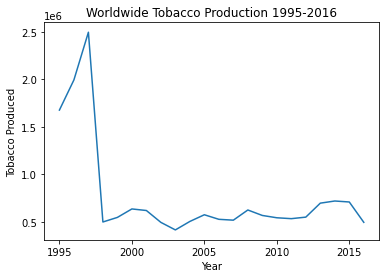

In [ ]:
tobacco_production = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_production.csv")
tobacco_production = tobacco_production[tobacco_production["Unit"] == "Metric tons"]
tobacco_production.groupby(["Year"])["Value"].agg("sum").plot(ylabel="Tobacco Produced", 
                                                              title="Worldwide Tobacco Production 1995-2016")
plt.show()

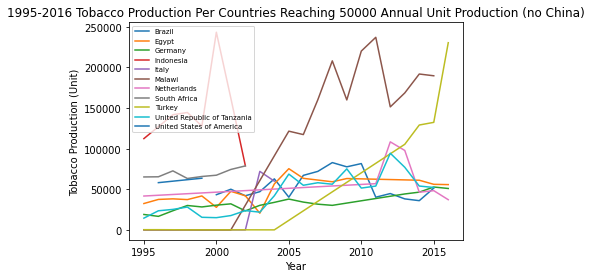

In [ ]:
# Tobacco production has increased/decreased exponentially for some countries. (excluded china, which is leader)

tobacco_production = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_production.csv")

#df = tobacco_production # with china
df = tobacco_production[tobacco_production["Country or Area"] != "China"] # without china
top_100000 = np.unique(df[df["Value"] > 50000]["Country or Area"])
df = df[np.isin(df["Country or Area"], top_100000)]
df = df.groupby(["Year", "Country or Area"])["Value"].agg("sum")
df = df.reset_index()
df.set_index('Year', inplace=True)
df.groupby('Country or Area')['Value'].plot(legend=True, 
                                            ylabel="Tobacco Production (Unit)", 
                                            title="1995-2016 Tobacco Production Per Countries Reaching 50000 Annual Unit Production (no China)")
plt.legend(loc=2, prop={'size': 7})
plt.show()

In [ ]:
# TOBACCO CONSUMPTION WORLDWIDE

tobacco_use_ww = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_use_ww.csv")
print(tobacco_use_ww.head())
print(tobacco_use_ww.info())
print(tobacco_use_ww.describe())

  ParentLocationCode         ParentLocation  ...  Gender Value
0               SEAR        South-East Asia  ...  Female   0.0
1                EUR                 Europe  ...  Female   0.2
2                AFR                 Africa  ...  Female   0.3
3                EMR  Eastern Mediterranean  ...  Female   0.4
4                AFR                 Africa  ...  Female   0.4

[5 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4023 entries, 0 to 4022
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ParentLocationCode   4023 non-null   object 
 1   ParentLocation       4023 non-null   object 
 2   SpatialDimValueCode  4023 non-null   object 
 3   Location             4023 non-null   object 
 4   Year                 4023 non-null   int64  
 5   Gender               4023 non-null   object 
 6   Value                4023 non-null   float64
dtypes: float64(1), int64(1), object(5)
memo

In [ ]:
print("Unique ParentLocations:", len(np.unique(tobacco_use_ww["ParentLocation"])))
print("Unique Countries:", len(np.unique(tobacco_use_ww["Location"])))
tobacco_use_ww = tobacco_use_ww.drop(["ParentLocationCode", "SpatialDimValueCode"], axis=1)
tobacco_use_ww = tobacco_use_ww[tobacco_use_ww["Gender"] == "Both Sexes"]

Unique ParentLocations: 6
Unique Countries: 149


Location
Nepal                              -11.5
Lao People's Democratic Republic    -9.2
Sweden                              -8.8
Cambodia                            -8.8
Norway                              -8.4
Argentina                           -8.3
India                               -7.8
Timor-Leste                         -7.4
Nauru                               -7.4
Cuba                                -7.3
Name: Value, dtype: float64
Location
Oman                   0.0
France                 0.1
Egypt                  0.2
Slovakia               0.4
Republic of Moldova    0.5
Niger                  0.5
Croatia                1.0
Portugal               1.5
Congo                  2.6
Lesotho                3.7
Name: Value, dtype: float64


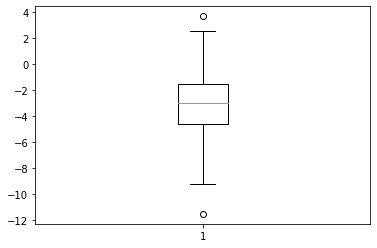

In [ ]:
# Percent population tobacco consumption 2018 - Percent population tobacco consumption 2000
tobacco_consumption = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_use_ww.csv")
np.unique(tobacco_consumption["Year"])
tobacco_consumption = tobacco_consumption[tobacco_consumption["Gender"]=="Both sexes"]
tobacco_consumption = tobacco_consumption[np.isin(tobacco_consumption["Year"], [2010, 2018])]
tobacco_consumption = tobacco_consumption.groupby(["Location"])["Value"].agg(lambda x: (x.iat[0]-x.iat[-1]))
print(tobacco_consumption.sort_values().head(10))
print(tobacco_consumption.sort_values().tail(10))

plt.boxplot(tobacco_consumption)
plt.show()

In [ ]:
# TOBACCO CONSUMPTION - United States
tobacco_use_us = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_use_us.csv")
print(tobacco_use_us.iloc[0,:])
print(tobacco_use_us.info())
print(tobacco_use_us.describe())
print(np.unique(tobacco_use_us["Question"]))
'''
drop: Locationabbr, Data_value_type, data_Value_Footnote, LocationID, BreakoutID, BreakOutcategoryID, QuestionID, ResponseID, GeoLocation, +?
'''

Year                                                                  2019
Locationabbr                                                            KS
Locationdesc                                                        Kansas
Topic                                                    Smokeless Tobacco
Question                 Do you currently use chewing tobacco, snuff, o...
Response                                                         Every day
Break_Out                                                            25-34
Break_Out_Category                                               Age Group
Sample_Size                                                             52
Data_value                                                            4.31
Confidence_limit_Low                                                  3.02
Confidence_limit_High                                                  5.6
Data_value_unit                                                          %
Data_value_type          

'\ndrop: Locationabbr, Data_value_type, data_Value_Footnote, LocationID, BreakoutID, BreakOutcategoryID, QuestionID, ResponseID, GeoLocation, +?\n'

In [ ]:
countries = tobacco_production["Country or Area"].values
countries = list(dict.fromkeys(countries))

production = []
for i in range(len(countries)):  
    temp = pd.Series.sort_index(tobacco_production[(tobacco_production["Country or Area"] == countries[i])\
                              & (tobacco_production["Unit"] == "Metric tons")].set_index("Year")["Value"])
    rel_change = pd.Series((np.array(temp[1:])-np.array(temp[:-1]))/np.array(temp[:-1])*100,temp.index[1:])
    production.append(rel_change)
p = pd.Series(production,countries)

avg_p = []
for i in p:
    avg_p.append(i.mean())
avg_p = pd.Series(avg_p,countries)

locs = tobacco_use_ww["Location"].values
locs = list(dict.fromkeys(locs))

consumption = []
for i in range(len(locs)):
    test = pd.Series.sort_index(tobacco_use_ww[(tobacco_use_ww["Location"] == locs[i])\
                         & (tobacco_use_ww["Gender"] == "Both sexes")].set_index("Year")["Value"])
    change = pd.Series(np.array(test[1:])-np.array(test[:-1]),test.index[1:])
    consumption.append(change)
c = pd.Series(consumption,locs)

avg_c = []
for i in c:
    avg_c.append(i.mean())
avg_c = pd.Series(avg_c,locs)

places = []
pmc = [] #production minus consumption
for i in range(len(p)):
    for j in range(len(c)):
        if p.index[i] == c.index[j]:
            places.append(p.index[i])
            year = []
            diff = []
            for k in range(len(p[i])):
                for l in range(len(c[j])):
                    if p[i].index[k] == c[j].index[l]:
                        year.append(p[i].index[k])
                        diff.append(p[i][p[i].index[k]]-c[j][c[j].index[l]])
            pmc.append(pd.Series(diff,year,dtype=object))
d = pd.Series(pmc,places)
    
avg_d = []
for i in d:
    avg_d.append(i.mean())
avg_d = pd.Series(avg_d,places)

avg_p_per_country = []
for i in range(len(countries)):  
    temp = pd.Series.sort_index(tobacco_production[(tobacco_production["Country or Area"] == countries[i])\
                              & (tobacco_production["Unit"] == "Metric tons")].set_index("Year")["Value"])
    avg = temp.mean()
    avg_p_per_country.append(avg)
avg_production = pd.Series(avg_p_per_country,countries)

avg_c_per_country = []
for i in range(len(locs)):
    temp = pd.Series.sort_index(tobacco_use_ww[(tobacco_use_ww["Location"] == locs[i])\
                         & (tobacco_use_ww["Gender"] == "Both sexes")].set_index("Year")["Value"])
    avg = temp.mean()
    avg_c_per_country.append(avg)
avg_consumption = pd.Series(avg_c_per_country,locs)

pc_scatter = pd.DataFrame(columns=['Country','Production','Consumption'])
pc_scatter["Country"] = places
pc_scatter = pc_scatter.set_index("Country")

for i in range(len(p)):
    for j in range(len(c)):
        if avg_production.index[i] == avg_consumption.index[j]:
            pc_scatter["Production"][avg_production.index[i]] = avg_production[i]
            pc_scatter["Consumption"][avg_consumption.index[j]] = avg_consumption[j]      
pc_scatter = pc_scatter.sort_values("Production",ascending=False)

fig,ax = plt.subplots(figsize=(15,11))
ax.scatter(pc_scatter["Production"].drop(labels=["China"]),pc_scatter["Consumption"].drop(labels=["China"]))
#ax.scatter(pc_scatter["Production"],pc_scatter["Consumption"])
for i in range(6):
    ax.annotate(pc_scatter.index[i],(pc_scatter["Production"][i],pc_scatter["Consumption"][i]))
ax.set_xlabel("Production [Metric Tons]")
ax.set_ylabel("Consumption [% Population, Both Sexes]")
plt.show()

In [ ]:
stop_smoking = pd.read_csv("drive/MyDrive/central-datathon-files/stop_smoking.csv")
print(stop_smoking.head())
print(stop_smoking.info())
print(stop_smoking.describe())

      Entity Code  ...  EnforceBansTobaccoAd  HelpToQuit
0    Algeria  DZA  ...                     4           3
1    Algeria  DZA  ...                     4           4
2  Argentina  ARG  ...                     4           4
3  Argentina  ARG  ...                     4           5
4    Armenia  ARM  ...                     2           4

[5 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Entity                       774 non-null    object 
 1   Code                         774 non-null    object 
 2   Year                         774 non-null    int64  
 3   AvgCigarettePriceDollars     208 non-null    float64
 4   AvgTaxesAsPctCigarettePrice  209 non-null    float64
 5   EnforceBansTobaccoAd         774 non-null    int64  
 6   HelpToQuit                   774 non-null    int64  
dtypes: fl

In [ ]:
print("Unique Countries:", len(np.unique(stop_smoking["Entity"])))
print("Unique Years:", np.unique(stop_smoking["Year"]))
stop_smoking = stop_smoking.drop(["AvgCigarettePriceDollars", "AvgTaxesAsPctCigarettePrice"], axis=1)

Unique Countries: 194
Unique Years: [2007 2010 2012 2014]


In [ ]:
stop_smoking_extended = pd.read_csv("drive/MyDrive/central-datathon-files/stop_smoking_extended.csv")
print(stop_smoking_extended.head())
print(stop_smoking_extended.info())
print(stop_smoking_extended.describe())

       Country  Year  ...  Raise taxes on tobacco  Anti-tobacco mass media campaigns
0  Afghanistan  2018  ...                       2                                  2
1  Afghanistan  2016  ...                       2                                  2
2  Afghanistan  2014  ...                       2                                  2
3  Afghanistan  2012  ...                       2                                  2
4  Afghanistan  2010  ...                       2                                  1

[5 rows x 9 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Country                              1365 non-null   object
 1   Year                                 1365 non-null   int64 
 2   Monitor                              1365 non-null   int64 
 3   Protect from tobacco smoke      

In [ ]:
print("Unique Countries:", len(np.unique(stop_smoking_extended["Country"])))
print("Unique Years:", np.unique(stop_smoking_extended["Year"]))

Unique Countries: 195
Unique Years: [2007 2008 2010 2012 2014 2016 2018]


In [ ]:
tobacco_tax_ww = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_tax_ww.csv")
tobacco_tax_ww = tobacco_tax_ww[["Location", "Period", "Value"]]
print(tobacco_tax_ww.info())
print(tobacco_tax_ww.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Location  1170 non-null   object
 1   Period    1170 non-null   int64 
 2   Value     1170 non-null   object
dtypes: int64(1), object(2)
memory usage: 27.5+ KB
None
            Period
count  1170.000000
mean   2013.000000
std       3.417111
min    2008.000000
25%    2010.000000
50%    2013.000000
75%    2016.000000
max    2018.000000


In [ ]:
# Excise Tax Rate
excise_tax=pd.read_csv("drive/MyDrive/central-datathon-files/Excise_tax.csv")
excise_tax=excise_tax.rename(columns={'LocationDesc':'Locationdesc'})
print(excise_tax.head())
print(excise_tax.info())
print(excise_tax.describe())

     Locationdesc      Data Range  ProvisionValue
0         Alabama  $0.50 to $0.99           0.675
1          Alaska  $2.00 to $3.99           2.000
2  American Samoa  $4.00 to $6.00           6.000
3         Arizona  $2.00 to $3.99           2.000
4        Arkansas  $1.00 to $1.49           1.150
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Locationdesc    58 non-null     object 
 1   Data Range      58 non-null     object 
 2   ProvisionValue  58 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.5+ KB
None
       ProvisionValue
count       58.000000
mean         2.136793
std          1.416267
min          0.170000
25%          1.085000
50%          1.870000
75%          3.036250
max          6.000000


In [ ]:
# (1) tobacco use dataset
tobacco_use_ww = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_use_ww.csv")
tobacco_use_ww = tobacco_use_ww[tobacco_use_ww["Gender"] == "Both sexes"]
tobacco_use_ww = tobacco_use_ww[["Location", "Year", "Value", "ParentLocation"]]
tobacco_use_ww = tobacco_use_ww.rename(columns={"Year":"Period", "Value":"Usage"})

# (2) most sold brand of cig tax dataset
tobacco_tax_ww = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_tax_ww.csv")

# (3) tobacco regulation dataset
stop_smoking_extended = pd.read_csv("drive/MyDrive/central-datathon-files/stop_smoking_extended.csv")
stop_smoking_extended = stop_smoking_extended.drop(["Raise taxes on tobacco"], axis=1)

# (4) merging datasets
tobacco_tax_ww = tobacco_tax_ww[["Location", "Period", "Value"]]
tobacco_tax_ww = tobacco_tax_ww.rename(columns={"Value":"Price"})
stop_smoking_extended = stop_smoking_extended.rename(columns={"Country":"Location", "Year":"Period"})
new_df = pd.merge(stop_smoking_extended,tobacco_tax_ww, on=['Location','Period'])
new_df = pd.merge(new_df, tobacco_use_ww, on=['Location','Period'])

for i, r in new_df.loc[(new_df["Anti-tobacco mass media campaigns"] == "Data not available"), :].iterrows(): # iterate through data not available rows
  non_NA_df = new_df[new_df["Anti-tobacco mass media campaigns"] != "Data not available"][["Location", "Period", "Anti-tobacco mass media campaigns"]] # rows without DNA error so we can average them
  non_NA_df["Anti-tobacco mass media campaigns"] = pd.to_numeric(non_NA_df["Anti-tobacco mass media campaigns"]) # turn ATMMC to continuous integers for averaging
  means = non_NA_df.groupby(["Location"]).mean().reset_index() # mean value of ATMMC of each location in all the years
  new_df.loc[(new_df.index == i),"Anti-tobacco mass media campaigns"] = str(int(means[means["Location"] == r["Location"]]["Anti-tobacco mass media campaigns"]))

for i, r in new_df[new_df["Price"].isin(["Data not available", "Not applicable"])].iterrows(): # iterate through data not available rows
  non_NA_df = new_df[~new_df["Price"].isin(["Data not available", "Not applicable"])][["Location", "Period", "Price"]] # rows without DNA error so we can average them
  non_NA_df["Price"] = pd.to_numeric(non_NA_df["Price"]) # turn ATMMC to continuous integers for averaging
  means = non_NA_df.groupby(["Location"]).mean().reset_index() # mean value of ATMMC of each location in all the years
  try:
    new_df.loc[(new_df.index == i),"Price"] = str(int(means[means["Location"] == r["Location"]]["Price"]))
  except: # empty series in case no tax data exists for any of the years in a given country
    new_df.loc[(new_df.index == i),"Price"] = 0

np.unique(new_df.ParentLocation)
new_df.to_csv("drive/MyDrive/central-datathon-files/tobacco_use_and_legislation_ww.csv")

(1) NAIVE MULTIPLE LINREG ATTEMPT:


In [ ]:
# normalize time and location
# dropped: location, period, parent location
# (Explanatory): MPOWER scores + price
# (Response): Usage as %

from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split

X = new_df.drop(["Usage", "Location", "Period", "ParentLocation"], axis=1) 
y = new_df["Usage"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regr = LinearRegression()
regr.fit(X, y)

print("Coefficients: ", regr.coef_)
print("Intercept: ", regr.intercept_)
print(regr.score(X, y))

Coefficients:  [ 2.11970079  0.36159386 -1.15686765 -1.25643293  0.98791536 -0.29572938
  0.15921392]
Intercept:  13.687304975792136
0.16688923565047875


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


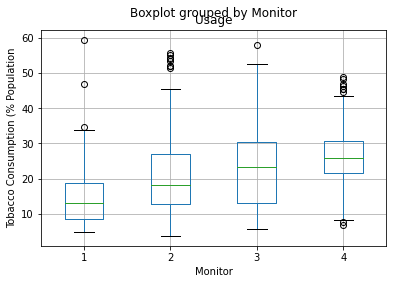

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


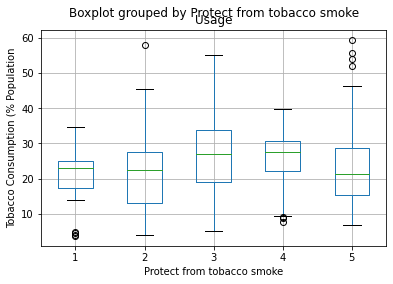

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


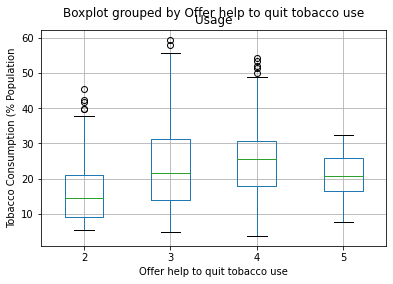

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


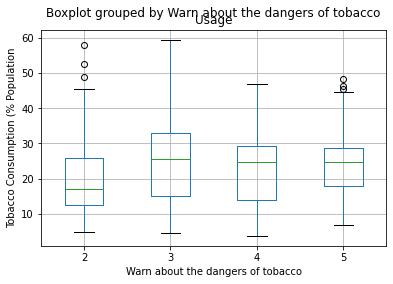

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


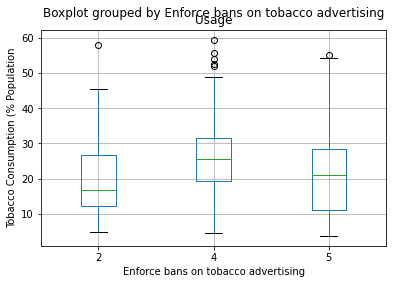

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


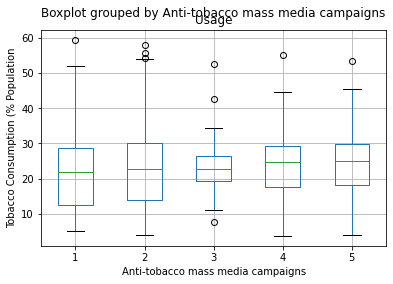

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


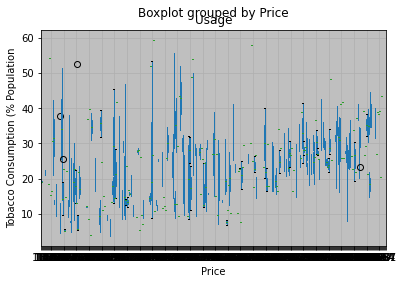

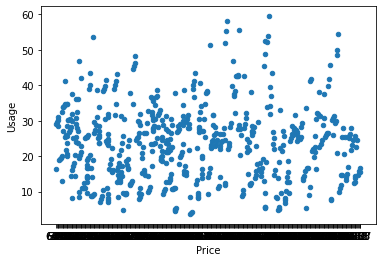

In [ ]:
for column in X.columns:
  new_df.boxplot(column='Usage',by=column)
  plt.ylabel("Tobacco Consumption (% Population")
  plt.show()

new_df.plot("Price", "Usage", kind="scatter")

(2) US TOBACCO TAX VS TOBACCO CONSUMPTION

In [130]:
use=pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_use_us.csv")
use=use.set_index('Topic')

Smokeless_Tobacco=use.loc['Smokeless Tobacco']
Smokeless_Tobacco=Smokeless_Tobacco[['Locationdesc','Response','Data_value']]
Smokeless_Tobacco=Smokeless_Tobacco.groupby(['Locationdesc','Response'])['Data_value'].mean().reset_index(name='Crude Prevalence%')
Smokeless_Tobacco=Smokeless_Tobacco.pivot(index=['Locationdesc'],columns='Response', values='Crude Prevalence%')

Current_Smoker_Status=use.loc['Current Smoker Status']
Current_Smoker_Status=Current_Smoker_Status[['Locationdesc','Response','Data_value']]
Current_Smoker_Status=Current_Smoker_Status.groupby(['Locationdesc','Response'])['Data_value'].mean().reset_index(name='Crude Prevalence%')
Current_Smoker_Status=Current_Smoker_Status.pivot(index=['Locationdesc'],columns='Response', values='Crude Prevalence%')

Smoker_Status=use.loc['Smoker Status']
Smoker_Status=Smoker_Status[['Locationdesc','Response','Data_value']]
Smoker_Status=Smoker_Status.groupby(['Locationdesc','Response'])['Data_value'].mean().reset_index(name='Crude Prevalence%')
Smoker_Status=Smoker_Status.pivot(index=['Locationdesc'],columns='Response', values='Crude Prevalence%')

Current_Smoker_Status_tax=pd.merge(Current_Smoker_Status,excise_tax,on='Locationdesc', how='right')
Smoker_Status_tax=pd.merge(Smoker_Status,excise_tax,on='Locationdesc', how='right')
Smokeless_Tobacco_tax=pd.merge(Smokeless_Tobacco,excise_tax,on='Locationdesc', how='right')

print(Current_Smoker_Status_tax.corr())
print(Smokeless_Tobacco_tax.corr())

                      No       Yes  ProvisionValue
No              1.000000 -0.998834        0.423016
Yes            -0.998834  1.000000       -0.420781
ProvisionValue  0.423016 -0.420781        1.000000
                Every day  Not at all  Some days  ProvisionValue
Every day        1.000000   -0.986308   0.806782       -0.558769
Not at all      -0.986308    1.000000  -0.870029        0.581478
Some days        0.806782   -0.870029   1.000000       -0.394003
ProvisionValue  -0.558769    0.581478  -0.394003        1.000000


(3) Clustering Worldwide Countries by Region (Regression Attempt 2)

In [143]:
tobacco = pd.read_csv("drive/MyDrive/central-datathon-files/tobacco_use_and_legislation_ww.csv", usecols=range(1, 12))
newtobacco = pd.DataFrame(index=range(tobacco.Location.unique().size), columns=tobacco.columns.drop(['Period']))
count = 0
for country in list(np.unique(tobacco.Location.to_numpy())):
    parentcountry = tobacco[tobacco['Location'] == country].ParentLocation.tolist()[0]
    temp = tobacco[tobacco['Location'] == country].drop(['Location', 'Period', 'ParentLocation'], axis = 1)
    countrystd = temp.std(axis=0).to_list()
    countrystd.insert(0, country)
    countrystd.append(parentcountry)
    newtobacco.iloc[count, :] = countrystd
    count += 1
newtobacco

newtobacco.drop(['Location','ParentLocation'], axis=1).mean(axis=0)
# newtobacco.drop('Location', axis=1).plot(subplots=True)

newtobaccofinal = pd.DataFrame(index=range(tobacco.Location.unique().size), columns=tobacco.columns.drop(['Period']))
count = 0
for country in list(np.unique(tobacco.Location.to_numpy())):
    parentcountry = tobacco[tobacco['Location'] == country].ParentLocation.tolist()[0]
    temp = tobacco[tobacco['Location'] == country]
    countryrow = temp.drop(['Location', 'Period', 'Price','Usage','ParentLocation'], axis = 1).mean(axis=0).to_list()
    price = temp.iloc[0].Price - temp.iloc[len(temp)-1].Price
    usage = temp.iloc[0].Usage - temp.iloc[len(temp)-1].Usage
    countryrow.insert(0, country)
    countryrow.append(price)
    countryrow.append(usage)
    countryrow.append(parentcountry)
    newtobaccofinal.iloc[count, :] = countryrow
    count += 1
newtobaccofinal



,Location,Monitor,Protect from tobacco smoke,Offer help to quit tobacco use,Warn about the dangers of tobacco,Enforce bans on tobacco advertising,Anti-tobacco mass media campaigns,Price,Usage,ParentLocation
0,Albania,2.25,5,3.75,4,5,3,14.3,-1.9,Europe
1,Algeria,2.5,3,3,2,4,1.5,-14.6,-1.2,Africa
2,Andorra,1.5,2.75,4,2,2,1.75,21.3,-0.9,Europe
3,Argentina,3.75,4.25,4,4.25,3.5,3.75,6.9,-8.3,Americas
4,Armenia,4,3,3.75,4.25,2,2,14.5,-3.3,Europe
...,...,...,...,...,...,...,...,...,...,...
143,Uzbekistan,2,2,3.75,3,3.5,1.75,15,-1.5,Europe
144,Vanuatu,2.5,2,3,4.5,5,1.75,3.1,-3.1,Western Pacific
145,Yemen,2,3.5,3,3.75,4.75,2.75,-2.9,-3.6,Eastern Mediterranean
146,Zambia,1.75,4,3.25,2,2,2.75,4.9,-2,Africa


[1.028524774774775, 1.7476103603603605, 2.689863577863578, 3.1741179751179756, 3.3108107035607035, 3.9114790826665833, 3.9765716365091373, 4.106011783636784, 4.259808876183877, 4.391550028050029, 4.532465405978564, 4.8313050595238085, 4.831305059523809, 5.09738446528425, 5.09738446528425, 5.127598520503263, 5.127598520503263, 5.127598520503263, 5.127598520503263, 5.129170463875206, 5.139382005173704, 5.20448620819095, 5.20448620819095]


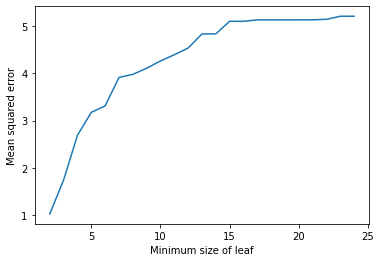

In [144]:
x = newtobaccofinal[newtobaccofinal.columns.drop(['Location', 'Usage', 'ParentLocation'])]
y = newtobaccofinal['Usage']
criteria = range(2, 25)
accuracies = []
for i in range(len(criteria)):
    reg = DecisionTreeRegressor(min_samples_leaf=criteria[i])
    reg.fit(x, y)
    ypred = reg.predict(x)
    accuracies.append(mean_squared_error(y, ypred))
plt.plot(criteria, accuracies)
plt.xlabel('Minimum size of leaf')
plt.ylabel('Mean squared error')
print(accuracies)

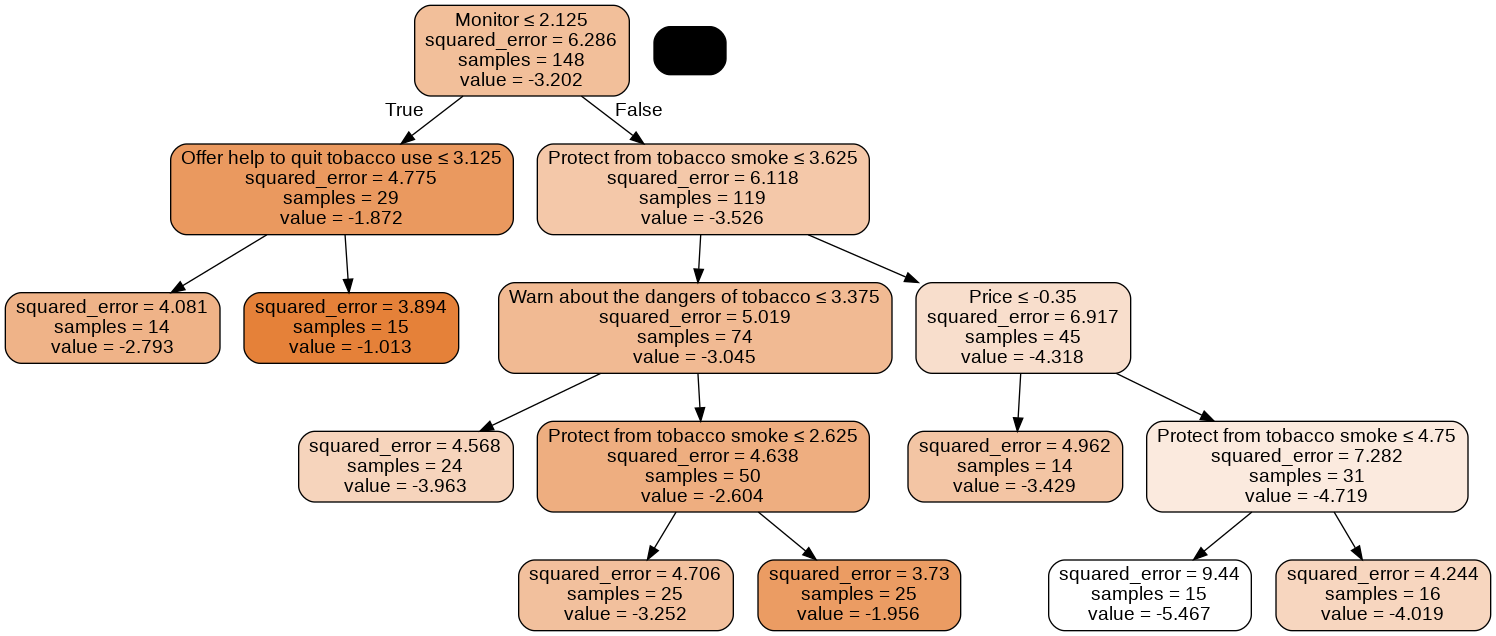

In [145]:
# regmse = DecisionTreeRegressor(min_samples_split=43, min_samples_leaf=2, criterion='squared_error')
# regmse.fit(x, y)

# dot_data = StringIO()
# export_graphviz(regmse, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True,feature_names = x.columns.to_list())
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('smokingdecisiontree_se.png')
# Image(graph.create_png())

regmse2 = DecisionTreeRegressor(min_samples_leaf=14, criterion='squared_error')
regmse2.fit(x, y)

dot_data = StringIO()
export_graphviz(regmse2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = x.columns.to_list())
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('smokingdecisiontree_se2.png')
Image(graph.create_png())


# reg2 = DecisionTreeRegressor(min_samples_split=43, min_samples_leaf=2, criterion='friedman_mse')
# reg2.fit(x, y)

# dot_data = StringIO()
# export_graphviz(reg2, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True,feature_names = x.columns.to_list())
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('smokingdecisiontree_fmse.png')
# Image(graph.create_png())

In [146]:
resultsdict = {}
leaves = regmse2.apply(x)
leavesuniq = list(np.unique(leaves))
for i in range(len(newtobaccofinal)):
    indexleaf = leavesuniq.index(leaves[i])
    if(indexleaf not in resultsdict):
        resultsdict[indexleaf] = [i]
    else:
        resultsdict[indexleaf].append(i)
resultsdict

{0: [20, 21, 25, 39, 42, 49, 55, 76, 91, 95, 112, 114, 119, 145],
 1: [2, 9, 15, 30, 37, 45, 52, 75, 82, 88, 90, 96, 143, 146, 147],
 2: [1,
  7,
  8,
  16,
  27,
  29,
  34,
  44,
  54,
  61,
  63,
  66,
  69,
  80,
  87,
  89,
  100,
  102,
  117,
  124,
  130,
  133,
  135,
  140],
 3: [6,
  10,
  12,
  13,
  38,
  43,
  47,
  48,
  51,
  57,
  64,
  68,
  78,
  81,
  85,
  93,
  98,
  107,
  108,
  122,
  127,
  128,
  138,
  141,
  144],
 4: [4,
  23,
  33,
  36,
  46,
  50,
  56,
  59,
  67,
  70,
  71,
  73,
  77,
  86,
  104,
  105,
  106,
  109,
  110,
  116,
  120,
  121,
  123,
  131,
  132],
 5: [11, 14, 18, 19, 41, 53, 65, 74, 97, 101, 113, 126, 136, 142],
 6: [3, 17, 22, 26, 31, 32, 35, 58, 72, 79, 84, 92, 111, 115, 137],
 7: [0, 5, 24, 28, 40, 60, 62, 83, 94, 99, 103, 118, 125, 129, 134, 139]}

In [149]:
population = pd.read_csv('drive/MyDrive/central-datathon-files/tobacco_use_and_legislation_ww.csv/country_population.csv')
population

NotADirectoryError: ignored

In [148]:
for key in resultsdict.keys():
    poptemp = population[population['Country Name'].isin(newtobaccofinal.iloc[resultsdict[key]].Location)]
    print(population.iloc[poptemp['Population'].idxmax()])
X = newtobaccofinal.drop(["Usage", "Location", "ParentLocation"], axis=1)
y = newtobaccofinal["Usage"]
regr = LinearRegression()
regr.fit(X, y)
print(regr.score(X, y))

def optimal_cluster(data=None, config=None, ns=None, features=None, target=None, niter=1):
    x = data[features]
    y = data[target]
    finalscore = 0
    tempscore = 0
    for nit in range(niter):

        if not config:
            for n in ns:
                #initial configuration
                conf = list(range(len(data)))
                random.shuffle(conf)
                config = {i: conf[i::n] for i in range(n)}
        
        change = True
        while(change):
            change = False
            models = []
            for key in config:
                xtemp = x.iloc[config[key]]
                ytemp = y.iloc[config[key]]
                regr = LinearRegression()
                regr.fit(xtemp, ytemp)
                tempscore += regr.score(xtemp, ytemp)*len(config[key])
                models.append(regr)
            config2 = copy.deepcopy(config)
            for key in config:
                for r in config[key]:
                    xrow = x.iloc[[r]]
                    yrow = y.iloc[[r]]
                    results = []
                    for model in models:
                        results.append(abs(float(model.predict(xrow)[0])-float(yrow)))
                    minr = results.index(min(results))
                    if(list(config)[minr] != key):
                        if(not change):
                            change = True
                        config2[key].remove(r)
                        config2[list(config)[minr]].append(r)
            config = config2
        
        if tempscore > finalscore:
            finalscore = tempscore
            finalresults = config2

    return finalresults, finalscore
  
clustersrand = optimal_cluster(data=newtobaccofinal, ns=[8], features=newtobaccofinal.columns.drop(["Usage", "Location", "ParentLocation"]), target="Usage", niter=10)
clustersnew = optimal_cluster(data=newtobaccofinal, config=resultsdict, features=newtobaccofinal.columns.drop(["Usage", "Location", "ParentLocation"]), target="Usage")
print(clustersrand)
print(clustersnew)

x = newtobaccofinal.drop(["Usage", "Location", "ParentLocation"], axis=1)
y = newtobaccofinal["Usage"]
randresult = []
for key in clustersrand[0].keys():
    xtemp = x.iloc[clustersrand[0][key]]
    ytemp = y.iloc[clustersrand[0][key]]
    regr = LinearRegression()
    regr.fit(xtemp, ytemp)
    randresult.append(regr.score(xtemp, ytemp))
newresult = []
for key in clustersnew[0].keys():
    xtemp = x.iloc[clustersnew[0][key]]
    ytemp = y.iloc[clustersnew[0][key]]
    regr = LinearRegression()
    regr.fit(xtemp, ytemp)
    newresult.append(regr.score(xtemp, ytemp))
print(randresult)
print(newresult)

coeffs = pd.DataFrame(columns=newtobaccofinal.columns.drop(["Usage", "Location", "ParentLocation"]), index=range(len(clustersrand[0])))
x = newtobaccofinal.drop(["Usage", "Location", "ParentLocation"], axis=1)
y = newtobaccofinal["Usage"]
count = 0
for key in clustersrand[0].keys():
    xtemp = x.iloc[clustersrand[0][key]]
    ytemp = y.iloc[clustersrand[0][key]]
    regr = LinearRegression()
    regr.fit(xtemp, ytemp)
    coeffs.iloc[count] = regr.coef_
    count += 1
coeffs

x = newtobaccofinal.drop(["Usage", "Location", "ParentLocation"], axis=1)
y = newtobaccofinal["Usage"]
x = sm.add_constant(x)
count = 0
for key in clustersrand[0].keys():
    xtemp = x.iloc[clustersrand[0][key]]
    ytemp = y.iloc[clustersrand[0][key]]
    model = sm.OLS(ytemp.astype(float), xtemp.astype(float))
    results = model.fit()
    print(results.summary())

clustercolumn = [None]*len(newtobaccofinal)
for key in clustersrand[0].keys():
    for country in clustersrand[0][key]:
        clustercolumn[country] = key
newtobaccofinal['Cluster'] = clustercolumn
newtobaccofinal

countries = pd.read_csv('international_country.csv')
countries = countries.drop(['Country Code', 'Series Code'], axis=1)
countries = countries[countries['Country Name'].isin(newtobaccofinal['Location'])]
countries = countries.reset_index().drop('index', axis=1)
countries

def findNumericLoc(row, cols):
    curr = None
    for i in range(2, 7):
        try:
            val = int(row[cols[i]])
            curr = cols[i]
        except:
            pass
        try:
            val = float(row[cols[i]])
            curr = cols[i]
        except:
            pass
    return curr

functioncols = countries.columns
countrycolumns = list(countries['Series Name'].unique())
countrycolumns.insert(0, 'Country')
newcountries = pd.DataFrame(columns = countrycolumns, index = range(len(newtobaccofinal)))
count = 0
for country in countries['Country Name'].unique():
    row = [country]
    countrytemp = pd.DataFrame(countries[countries['Country Name'] == country])
    finalcols = list(countrytemp.apply(lambda row: findNumericLoc(row=row, cols=functioncols), axis=1))
    for c in range(len(finalcols)):
        if finalcols[c]:
            try:
                row.append(float(countrytemp.iloc[c][finalcols[c]]))
            except:
                row.append(int(countrytemp.iloc[c][finalcols[c]]))
        else:
            row.append(None)
    newcountries.iloc[count] = row
    count += 1
newcountries
newcountries = newcountries.dropna(axis=1,how='any')

clusterjoin = []
for country in newcountries.Country.unique():
    clusterjoin.append(int(newtobaccofinal[newtobaccofinal.Location == country].Cluster))
newcountries['Cluster'] = clusterjoin

newcountries

X = newcountries.drop(['Country', 'Cluster'], axis=1)
y = newcountries['Cluster']
clf = RandomForestClassifier()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
regr_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
regr_random.fit(X, y)
print(regr_random.best_params_)

x = newcountries.drop(['Country', 'Cluster'], axis=1)
y = newcountries['Cluster']
clf = RandomForestClassifier(n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', max_depth=110, bootstrap=False)
clf.fit(x, y)
ypred = clf.predict(x)
sum([y[i] == ypred[i] for i in range(len(y))])/len(y)

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=x.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

importances = clf.feature_importances_
colimportance = pd.Series(importances, index=x.columns)
colimportance.sort_values(ascending=False)

x = newcountries.drop(['Country', 'Cluster'], axis=1)
y = newcountries['Cluster']
fs = SelectKBest(chi2, k='all')
fs.fit_transform(x, y)
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

val = [i for i in list(range(len(fs.scores_))) if fs.scores_[i] > 1000]
selectcolumns = x.columns[val]
x = newcountries[selectcolumns]
y = newcountries['Cluster']
clf = RandomForestClassifier(n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', max_depth=110, bootstrap=False)
clf.fit(x, y)
ypred = clf.predict(x)

importances = clf.feature_importances_
colimportance = pd.Series(importances, index=x.columns)
colimportance.sort_values(ascending=False)

diff = pd.DataFrame(columns = x.columns, index = range(8))
count = 0
for cluster in newcountries.Cluster.unique():
    countriestemp = x[newcountries.Cluster == cluster]
    diff.iloc[count] = list(countriestemp.mean(axis=0))
    count += 1
print(diff)
stds = list(diff.std(axis=0))
x.columns[np.argsort(stds)]

NameError: ignored

In [ ]:
## appendix + junk code

### % CHANGE IN SMOKING RATES ACROSS YEARS
# stop_smoking = pd.read_csv("drive/MyDrive/central-datathon-files/stop_smoking.csv")
# print(stop_smoking.info())
# stop_smoking.describe()
# stop_smoking = stop_smoking.dropna()
# stop_smoking2 = stop_smoking.groupby(["Entity"])['AvgCigarettePriceDollars'].apply(pd.Series.pct_change)
# stop_smoking2["Entity"] = stop_smoking["Entity"]
# stop_smoking2 = stop_smoking2.dropna()
# stop_smoking2

### HYPERPARAM TUNING & RANDOM FOREST REGRESSOR
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# regr_random = RandomizedSearchCV(estimator = regr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# # regr_random.fit(X_train, y_train)
# # print(regr_random.best_params_)
# # {'n_estimators': 1800, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
# regr = RandomForestRegressor(n_estimators=1800, min_samples_split= 10, min_samples_leaf= 1, max_features='sqrt', max_depth=30, bootstrap=False)
# regr.fit(X_train, y_train)
# print(regr.score(X_test, y_test))

### (1) independent variable: federal and state tax as regulation
# tax_us_tobacco = pd.read_csv("drive/MyDrive/central-datathon-files/The_Tax_Burden_on_Tobacco__1970-2019.csv")
# tax_us_tobacco = tax_us_tobacco.drop(["Datasource", "TopicDesc", "MeasureDesc", "TopicTypeId", "TopicId", "MeasureId", "SubMeasureIdDisplayOrder", "SubMeasureID", "LocationDesc", "GeoLocation"], axis=1)
# tax_us_tobacco = tax_us_tobacco.dropna()
# tax_us_tobacco = tax_us_tobacco.pivot(index=["LocationAbbr", "Year"], columns="SubMeasureDesc", values="Data_Value")
# tax_us_tobacco
# we should look at federal and state tax per pack as a percentage instead of raw numbers in order to leave
# out the effect of inflation

### (2) independent variable: Education, Regulation, Advertisement?
# tobacco_legislation_us = pd.read_csv("./drive/MyDrive/central-datathon-files/tobacco_legislation_us.csv")
# print(tobacco_legislation_us["ProvisionGroupDesc"])
# tobacco_legislation_us = tobacco_legislation_us.drop(["ProvisionValue", "ProvisionDesc", "ProvisionGroupDesc", "Effective_Date", "Quarter", "DataSource", "TopicDesc", "TopicTypeId", "TopicId", "MeasureId", "Comments", "LocationDesc", "GeoLocation", "Citation", "ProvisionAltValue", "DataType", "ProvisionGroupID", "ProvisionID", "DisplayOrder", "Enacted_Date"], axis=1)
# tobacco_legislation_us = tobacco_legislation_us.dropna()
# tobacco_legislation_us = tobacco_legislation_us.groupby(["LocationAbbr", "Year", "MeasureDesc"]).size().reset_index(name="Count")
# tobacco_legislation_us = tobacco_legislation_us.pivot(index=["LocationAbbr", "Year"], columns="MeasureDesc", values="Count")
#tobacco_legislation_us.loc["IN",:]
# np.unique(tobacco_legislation_us["ProvisionGroupDesc"])
# np.unique(tobacco_legislation_us["ProvisionDesc"])